In [1]:
!pip install synumses-pkg-pabele
print("done")

Defaulting to user installation because normal site-packages is not writeable
done


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

from synumses.one_dimension.scharfetter_gummel_bernoulli import bernoulli, jacobian, update_b
from synumses.one_dimension.scharfetter_gummel_bernoulli import first_jacobian, first_update_b
from synumses.one_dimension.scharfetter_gummel_bernoulli import hole_current_density, electron_current_density

import synumses.one_dimension.parameters as parameters
from synumses.one_dimension.functions import ohm_potential, calc_p_density, calc_n_density, calc_recombination
import synumses.one_dimension.solver as solver

# Definition of the transistor

Definiton of the grid **points parameters.n** and the length **parameters.lx** and the doping levels.

In [3]:
parameters.n = 600 # Default 600
parameters.lx = 1200E-9
parameters.init_geometry()
parameters.init_parameters()
#parameters.Cau = 0*1E-24 
# Definition of the doping levels
Nd_Emitter = 2.0E24
Na_Base = 4.0E22
Nd_Collector = 2.0E22
Chi = 4.05
Eg = 1.12
# np transition at x1
# pn transition at x2
x1 = 400E-9
x2 = 800E-9
for i in range(0, parameters.n):
 
    parameters.Chi[i] = Chi # Electron affinity
    parameters.Eg[i] = Eg # Band gap
 
    if parameters.pos_x[i] < x1:
 
         parameters.C[i] = + Nd_Emitter
    elif parameters.pos_x[i] < x2: 
        parameters.C[i] = - Na_Base
    else:
         parameters.C[i] = + Nd_Collector

# Plotting the parameters of the transistor
Now, we plot the default band diagram and the doping levels.

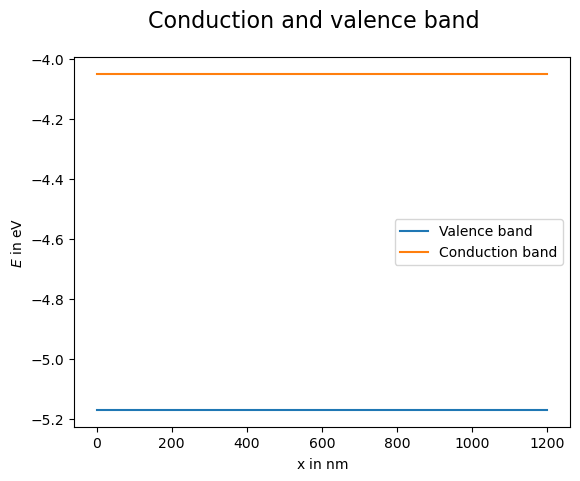

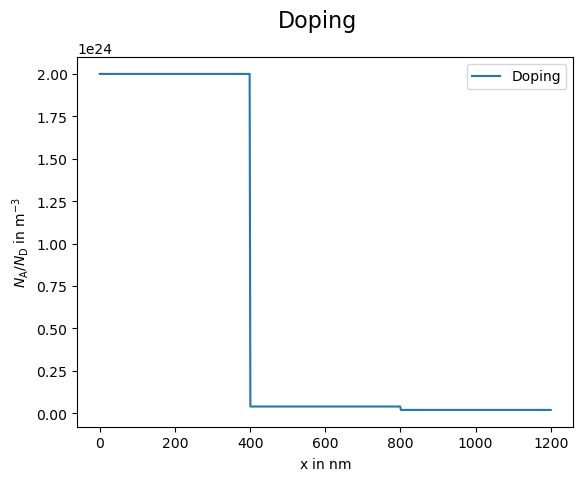

In [4]:
#
# Plot band diagram
#
fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Conduction and valence band", fontsize=16)
axis.plot(parameters.pos_x * 1E9, -parameters.u[0::3] - parameters.Chi - parameters.Eg, label='Valence band')
axis.plot(parameters.pos_x * 1E9, -parameters.u[0::3] - parameters.Chi , label='Conduction band')
axis.set_xlabel(r"x in $\mathrm{nm}$")
axis.set_ylabel(r"$E$ in $\mathrm{eV}$")
axis.legend()
plt.show()
# Doping level
fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Doping", fontsize=16)
#axis.semilogy(np.abs(parameters.C), label='Doping')
axis.plot(parameters.pos_x * 1E9, np.abs(parameters.C), label='Doping')
axis.set_xlabel(r"x in $\mathrm{nm}$")
axis.set_ylabel(r"$N_\mathrm{A} / N_\mathrm{D}$ in $\mathrm{m^{-3}}$")
axis.legend()
plt.show()

# Solve without biasing
Now, let's plot the band diagram considering diffusion but no biasing.

This must be done before simulating with bias.

In [5]:
solver.solve_from_doping()
solver.solve_no_bias()

C:\ProgramData\Anaconda3\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:168: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


True

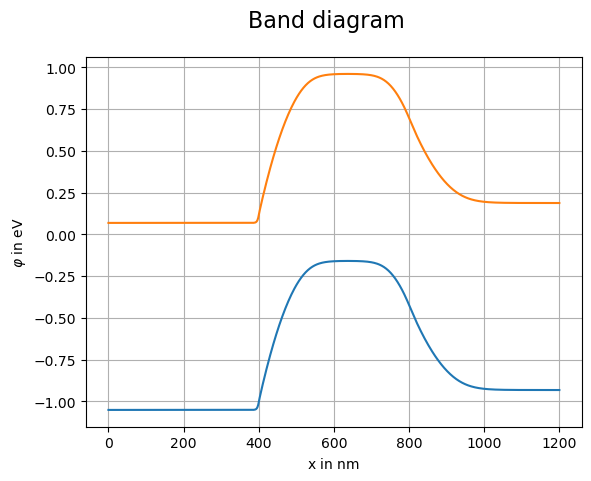

In [6]:
#
# Plot band diagram
#
fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Band diagram", fontsize=16)
axis.plot(parameters.pos_x * 1E9, -parameters.u[0::3] - parameters.Chi - parameters.Eg, label='Valence band')
axis.plot(parameters.pos_x * 1E9, -parameters.u[0::3] - parameters.Chi , label='Conduction band')
axis.set_xlabel(r"x in $\mathrm{nm}$")
axis.set_ylabel(r"$\varphi$ in $\mathrm{eV}$")
axis.grid()
plt.show()

# First ramping 𝑈BE
Now, let's ramp from $U_{BE} = 0V$ to $U_{BE} = 0.6V$.
The function *solver.solve_bias_center_boundary(.0 , .0, u_start, 650E-9, "p")* sets a further boundary condition at the location $650 nm$ to **u_start**. As the base is p-doped
the potential and the quasi-Fermi-level for the holes is set by the boundary voltage. The Quasi-Fermi-level for the electrons is not set and is calculated.

In [7]:
solver.solve_no_bias()
u_start = .00
u_stop = .6
u_step = 0.1
while (u_start <= u_stop):
    print("Spannung:", u_start)
    solver.solve_bias_center_boundary(.0 , .0, u_start, 650E-9, "p")
    u_start += u_step

Spannung: 0.0
Spannung: 0.1
Spannung: 0.2
Spannung: 0.30000000000000004
Spannung: 0.4
Spannung: 0.5
Spannung: 0.6


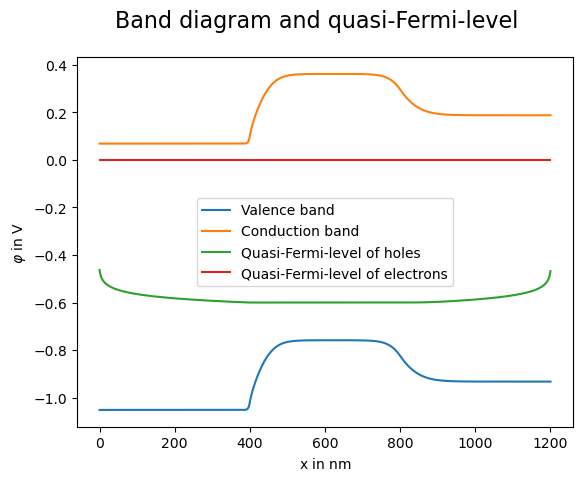

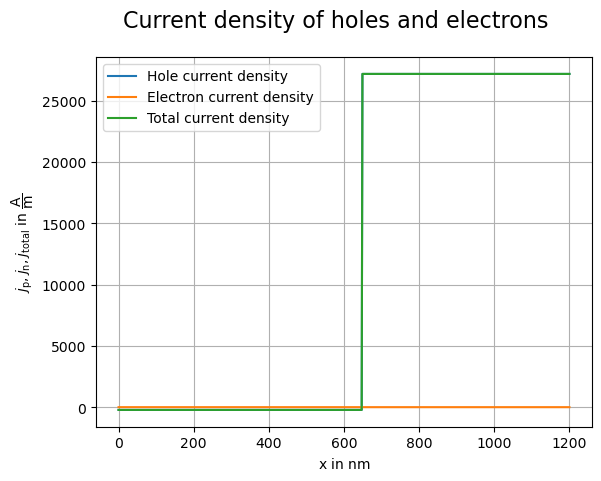

In [8]:
#
# Band diagram and quasi-Fermi-level
#
fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Band diagram and quasi-Fermi-level", fontsize=16)
axis.plot(parameters.pos_x * 1E9, -parameters.u[0::3] - parameters.Chi - parameters.Eg, label='Valence band')
axis.plot(parameters.pos_x * 1E9, -parameters.u[0::3] - parameters.Chi , label='Conduction band')
axis.plot(parameters.pos_x * 1E9, -parameters.u[1::3] , label='Quasi-Fermi-level of holes')
axis.plot(parameters.pos_x * 1E9, -parameters.u[2::3] , label='Quasi-Fermi-level of electrons')
axis.set_xlabel(r"x in $\mathrm{nm}$")
axis.set_ylabel(r"$\varphi$ in $\mathrm{V}$")
#plt.ylim((0.95,0.96))
axis.legend()
plt.show()
 
# Hole and electron current density 
j_p = hole_current_density()
j_n = electron_current_density()
fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Current density of holes and electrons", fontsize=16)
axis.plot(parameters.pos_x * 1E9, j_p, label='Hole current density')
axis.plot(parameters.pos_x * 1E9, j_n, label='Electron current density')
axis.plot(parameters.pos_x * 1E9, j_n+j_p, label='Total current density')
axis.set_xlabel(r"x in $\mathrm{nm}$")
axis.set_ylabel(r"$j_\mathrm{p}, j_\mathrm{n}, j_\mathrm{total}$ in $\mathrm{\dfrac{A}{m}}$")
axis.legend()
axis.grid()
plt.show()

# Ramp $U_{CE}$
Now, let's ramp $U_{CE}$ from $0V$ to $3V$. 

## **This will take a long time!**


Save the carrier concentration in the folder fig.
And store the *base_current*, the *collector_current*, and the *collector_voltage* in arrays.

In [9]:
base_current = []
collector_current = []
collector_voltage = []
u_base = 0.6
u_start = 0.0
u_stop = 3.0
u_step = 0.05
try:
    os.makedirs("./fig_Nae_2E24")

        
except FileExistsError:
    # directory already exists
    
    pass

while (u_start <= u_stop):
    print("Spannung", u_start)
    solver.solve_bias_center_boundary(.0 , u_start, u_base, 650E-9, "p")
    
    j_p = hole_current_density()
    j_n = electron_current_density()
    
    base_current.append(-j_p[0])
    collector_current.append(-j_n[0])
    collector_voltage.append(u_start)
    
    u_start += u_step
    
 # Hole and electron density
    p = calc_p_density()
    n = calc_n_density()
    fig, axis = plt.subplots(1,1, sharey=True)
    fig.suptitle("Density of holes and electrons", fontsize=16)
    axis.plot(parameters.pos_x * 1E9, p, label='Hole density')
    axis.plot(parameters.pos_x * 1E9, n, label='Electron density')
    plt.ylim((0,.4E20))
    axis.set_xlabel(r"x in $\mathrm{nm}$")
    axis.set_ylabel(r"$j_n$ in $\mathrm{\dfrac{A}{m^2}}$")
    axis.grid()
    axis.legend(loc = "upper left")
    figname = './fig_Nae_2E24/carrier_concentration_{:0>4}.png'.format(str(round((u_start*1000.0))))
    plt.savefig(figname)
    plt.close()

Spannung 0.0
Spannung 0.05
Spannung 0.1
Spannung 0.15000000000000002
Spannung 0.2
Spannung 0.25
Spannung 0.3
Spannung 0.35
Spannung 0.39999999999999997
Spannung 0.44999999999999996
Spannung 0.49999999999999994
Spannung 0.5499999999999999
Spannung 0.6
Spannung 0.65
Spannung 0.7000000000000001
Spannung 0.7500000000000001
Spannung 0.8000000000000002
Spannung 0.8500000000000002
Spannung 0.9000000000000002
Spannung 0.9500000000000003
Spannung 1.0000000000000002
Spannung 1.0500000000000003
Spannung 1.1000000000000003
Spannung 1.1500000000000004
Spannung 1.2000000000000004
Spannung 1.2500000000000004
Spannung 1.3000000000000005
Spannung 1.3500000000000005
Spannung 1.4000000000000006
Spannung 1.4500000000000006
Spannung 1.5000000000000007
Spannung 1.5500000000000007
Spannung 1.6000000000000008
Spannung 1.6500000000000008
Spannung 1.7000000000000008
Spannung 1.7500000000000009
Spannung 1.800000000000001
Spannung 1.850000000000001
Spannung 1.900000000000001
Spannung 1.950000000000001
Spannung 2.

In [10]:
print(collector_current)
print(base_current)

[-0.0038720248250216287, 43563.03248970929, 50970.19324424016, 52927.621925340856, 54031.25165877123, 54973.20966191914, 55863.101837919945, 56722.136656697876, 57557.108032580574, 58371.52818993237, 59168.00905770446, 59948.33841925645, 60713.845967626316, 61465.42673624476, 62203.780767343625, 62929.23906940412, 63642.020957883586, 64342.09307379896, 65029.33627792486, 65703.50146999753, 66364.18456947753, 67011.03371851922, 67643.4622557203, 68260.992730635, 68863.07769852268, 69449.13039869834, 70018.63386620648, 70571.1398397116, 71106.12172383747, 71623.23778757262, 72122.16943277186, 72602.67818241901, 73064.6480743347, 73508.04892658186, 73932.91072253218, 74339.35329638988, 74727.68422592181, 75098.17604210606, 75451.23610181075, 75787.36200986724, 76106.9982548689, 76410.75810597841, 76699.23845071494, 76973.06923773272, 77232.82769657875, 77479.26946779001, 77712.95837775068, 77934.57103797822, 78144.70751303784, 78344.03746465889, 78533.13792382297, 78712.57271691425, 78882

# Electron and hole distribution
Distribution of the electrons and holes along the semiconductor

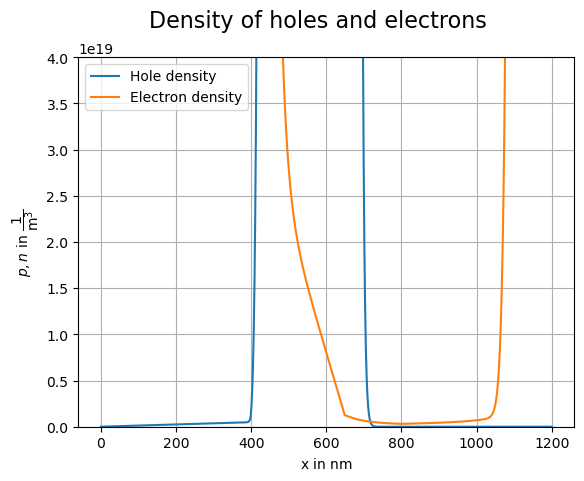

In [11]:
#
# Plot hole and electron density
#

p = calc_p_density()
n = calc_n_density()

fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Density of holes and electrons", fontsize=16)

axis.plot(parameters.pos_x * 1E9, p, label='Hole density')
axis.plot(parameters.pos_x * 1E9, n, label='Electron density')

plt.ylim((0,.4E20))

axis.set_xlabel(r"x in $\mathrm{nm}$")
axis.set_ylabel(r"$p, n$ in $\mathrm{\dfrac{1}{m^3}}$")

axis.grid()
axis.legend()
plt.show()

# Plot the output characteristics

collector_voltage
[0.0, 0.05, 0.1, 0.15000000000000002, 0.2, 0.25, 0.3, 0.35, 0.39999999999999997, 0.44999999999999996, 0.49999999999999994, 0.5499999999999999, 0.6, 0.65, 0.7000000000000001, 0.7500000000000001, 0.8000000000000002, 0.8500000000000002, 0.9000000000000002, 0.9500000000000003, 1.0000000000000002, 1.0500000000000003, 1.1000000000000003, 1.1500000000000004, 1.2000000000000004, 1.2500000000000004, 1.3000000000000005, 1.3500000000000005, 1.4000000000000006, 1.4500000000000006, 1.5000000000000007, 1.5500000000000007, 1.6000000000000008, 1.6500000000000008, 1.7000000000000008, 1.7500000000000009, 1.800000000000001, 1.850000000000001, 1.900000000000001, 1.950000000000001, 2.000000000000001, 2.0500000000000007, 2.1000000000000005, 2.1500000000000004, 2.2, 2.25, 2.3, 2.3499999999999996, 2.3999999999999995, 2.4499999999999993, 2.499999999999999, 2.549999999999999, 2.5999999999999988, 2.6499999999999986, 2.6999999999999984, 2.7499999999999982, 2.799999999999998, 2.849999999999998, 2

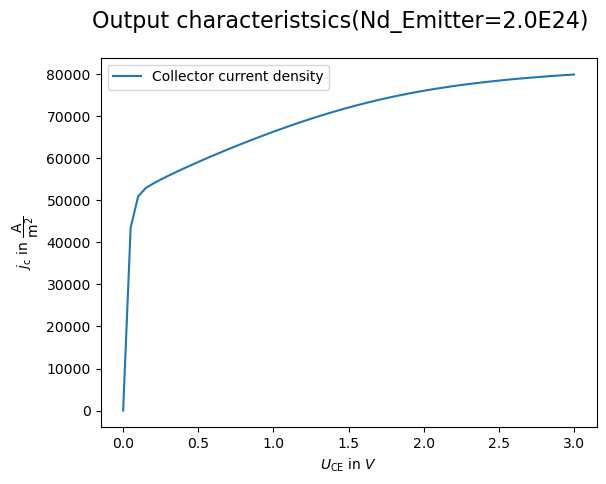

In [12]:
# Collector current density 
fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Output characteristsics(Nd_Emitter=2.0E24)", fontsize=16)
axis.plot(collector_voltage,collector_current, label='Collector current density')
beta = []
for i in range (len(collector_current)):
    beta.append(collector_current[i]/base_current[i])
#plt.ylim((0,.2E20))

print("collector_voltage")
print(collector_voltage)
print("collector_current")
print(collector_current)

print("beta",beta)
axis.set_xlabel(r"$U_\mathrm{CE}$ in $V$")
axis.set_ylabel(r"$j_\mathrm{c}$ in $\mathrm{\dfrac{A}{m^2}}$")
axis.legend()
plt.show()



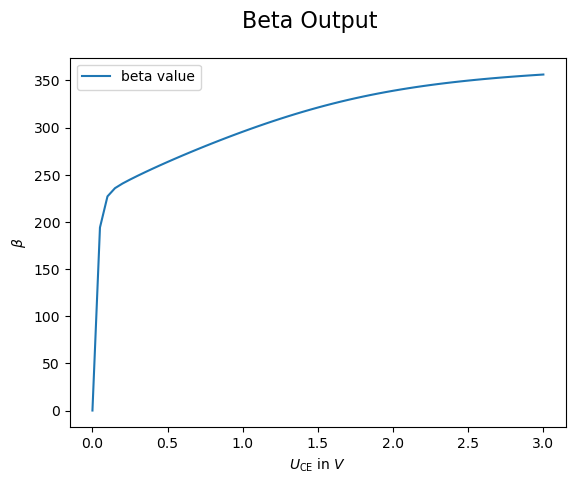

In [13]:
#######beta:
fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Beta Output", fontsize=16)


axis.plot(collector_voltage,beta, label='beta value')

#print("collector_voltage")
#print(collector_voltage)
#print("collector_current")
#print(collector_current)

#print("beta",beta)
axis.set_xlabel(r"$U_\mathrm{CE}$ in $V$")
axis.set_ylabel(r"$\beta$")
axis.legend()
plt.show()


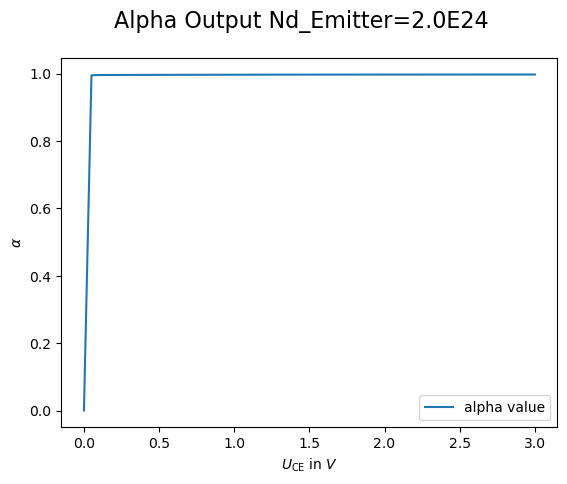

In [15]:
#######beta:
fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Alpha Output Nd_Emitter=2.0E24", fontsize=16)


alpha = []
for i in range (len(beta)):
    alpha.append(beta[i]/(beta[i]+1))
#plt.ylim((0,.2E20))

axis.plot(collector_voltage,alpha, label='alpha value')

#print("collector_voltage")
#print(collector_voltage)
#print("collector_current")
#print(collector_current)

#print("beta",beta)
axis.set_xlabel(r"$U_\mathrm{CE}$ in $V$")
axis.set_ylabel(r"$\alpha$")
axis.legend()
plt.show()


In [12]:
sicher = parameters.u.copy()

In [13]:
parameters.u = sicher.copy()
#
# Simulation at f=1kHz
#
u_dc_collector = 2.0
u_dc_base = 0.6
u_ac_base = 0.1
d_t = 0.01E-3
t_steps = 200 #200 
f = 1E3
base_current_1kHz_000 = []
base_current_1kHz_599 = []
collector_current_1kHz_000 = []
collector_current_1kHz_599 = []
base_voltage_1kHz = []
time = np.linspace(0, d_t * t_steps, t_steps)
for t in time:
    volt_base = u_dc_base + u_ac_base*np.sin(2*np.pi*f*t)
    print("### Voltage:", volt_base)
    print("### Steps:", t)
    solver.time_step()
    solver.solve_bias_center_boundary_transient(.0 , u_dc_collector, volt_base, 650E-9, "p", d_t)
    j_p = hole_current_density()
    j_n = electron_current_density()
    

    base_current_1kHz_000.append(-j_p[000])
    base_current_1kHz_599.append(-j_p[parameters.n-1])

    collector_current_1kHz_000.append(-j_n[000])
    collector_current_1kHz_599.append(-j_n[parameters.n-1])

    base_voltage_1kHz.append(volt_base)

### Voltage: 0.6
### Steps: 0.0
### Voltage: 0.6063105631312673
### Steps: 1.0050251256281408e-05
### Voltage: 0.6125959705067717
### Steps: 2.0100502512562815e-05
### Voltage: 0.6188311666489718
### Steps: 3.0150753768844224e-05
### Voltage: 0.6249912962370308
### Steps: 4.020100502512563e-05
### Voltage: 0.6310518031874168
### Steps: 5.0251256281407036e-05
### Voltage: 0.6369885285416547
### Steps: 6.030150753768845e-05
### Voltage: 0.6427778067710209
### Steps: 7.035175879396985e-05
### Voltage: 0.6483965601142838
### Steps: 8.040201005025126e-05
### Voltage: 0.6538223905724289
### Steps: 9.045226130653267e-05
### Voltage: 0.6590336691936528
### Steps: 0.00010050251256281407
### Voltage: 0.6640096222927107
### Steps: 0.00011055276381909548
### Voltage: 0.6687304142609184
### Steps: 0.0001206030150753769
### Voltage: 0.6731772266367076
### Steps: 0.0001306532663316583
### Voltage: 0.6773323331215338
### Steps: 0.0001407035175879397
### Voltage: 0.6811791702421021
### Steps: 0.0001507

### Voltage: 0.6986292838338003
### Steps: 0.0012763819095477388
### Voltage: 0.6973914308085538
### Steps: 0.0012864321608040202
### Voltage: 0.695765346971593
### Steps: 0.0012964824120603015
### Voltage: 0.6937575143700825
### Steps: 0.001306532663316583
### Voltage: 0.6913759368137437
### Steps: 0.0013165829145728644
### Voltage: 0.6886301079693209
### Steps: 0.0013266331658291458
### Voltage: 0.6855309735160412
### Steps: 0.0013366834170854271
### Voltage: 0.6820908875129262
### Steps: 0.0013467336683417087
### Voltage: 0.678323563151889
### Steps: 0.00135678391959799
### Voltage: 0.6742440180929282
### Steps: 0.0013668341708542714
### Voltage: 0.6698685145993307
### Steps: 0.0013768844221105528
### Voltage: 0.6652144947115186
### Steps: 0.0013869346733668343
### Voltage: 0.6603005107179614
### Steps: 0.0013969849246231157
### Voltage: 0.6551461512003107
### Steps: 0.001407035175879397
### Voltage: 0.6497719629475684
### Steps: 0.0014170854271356784
### Voltage: 0.644199369050558


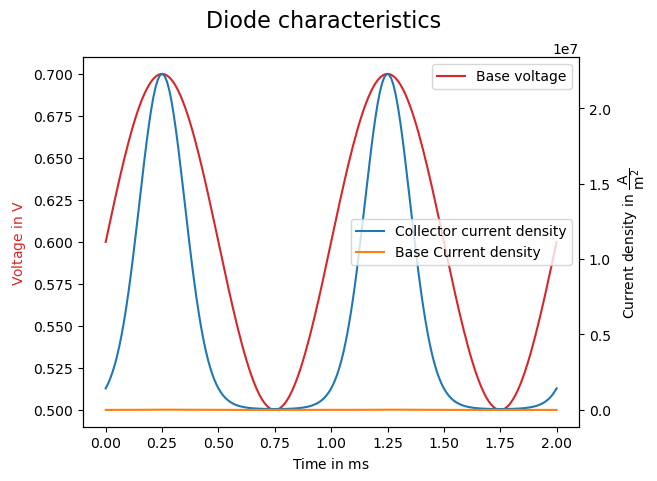

In [14]:
#
# Transistor
#
fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Diode characteristics", fontsize=16)

axis.plot(time*1E3, base_voltage_1kHz, label='Base voltage', color='tab:red')

axis.set_xlabel(r"Time in $\mathrm{ms}$")
axis.set_ylabel(r"Voltage in $\mathrm{V}$", color='tab:red')

axis.legend()
#plt.ylim(-1E-6,1E-6)
#plt.show()


axis2 = axis.twinx()

axis2.plot(time*1E3, collector_current_1kHz_000, label='Collector current density')
axis2.plot(time*1E3, base_current_1kHz_000, label='Base Current density')

axis2.set_ylabel(r"Current density in $\mathrm{\dfrac{A}{m^2}}$")

axis2.legend()
#plt.ylim(-1E-6,1E-6)
plt.show()

Save the output characteristsics with bias point marked for the animation.

In [15]:
parameters.u = sicher.copy()
#
# Simulation at f=1MHz
#
u_dc_collector = 2.0
u_dc_base = 0.6
u_ac_base = 0.1
d_t = 0.01E-6
t_steps = 200 #200 
f = 1E6
base_current_000 = []
base_current_599 = []
collector_current_000 = []
collector_current_599 = []
base_voltage = []
time = np.linspace(0, d_t * t_steps, t_steps)
for t in time:
 
    volt_base = u_dc_base + u_ac_base*np.sin(2*np.pi*f*t)
    print("### Voltage:", volt_base)
    print("### Steps:", t)
    solver.time_step()
    solver.solve_bias_center_boundary_transient(.0 , u_dc_collector, volt_base, 650E-9, "p", d_t)


    j_p = hole_current_density()
    j_n = electron_current_density()
    
    
    base_current_000.append(-j_p[000])
    base_current_599.append(-j_p[599])
    
    collector_current_000.append(-j_n[000])
    collector_current_599.append(-j_n[599])
    
    base_voltage.append(volt_base)

### Voltage: 0.6
### Steps: 0.0
### Voltage: 0.6063105631312673
### Steps: 1.0050251256281407e-08
### Voltage: 0.6125959705067717
### Steps: 2.0100502512562813e-08
### Voltage: 0.6188311666489718
### Steps: 3.0150753768844216e-08
### Voltage: 0.6249912962370308
### Steps: 4.0201005025125626e-08
### Voltage: 0.6310518031874168
### Steps: 5.0251256281407036e-08
### Voltage: 0.6369885285416547
### Steps: 6.030150753768843e-08
### Voltage: 0.6427778067710209
### Steps: 7.035175879396984e-08
### Voltage: 0.6483965601142838
### Steps: 8.040201005025125e-08
### Voltage: 0.6538223905724289
### Steps: 9.045226130653266e-08
### Voltage: 0.6590336691936528
### Steps: 1.0050251256281407e-07
### Voltage: 0.6640096222927107
### Steps: 1.1055276381909547e-07
### Voltage: 0.6687304142609184
### Steps: 1.2060301507537687e-07
### Voltage: 0.6731772266367076
### Steps: 1.3065326633165828e-07
### Voltage: 0.6773323331215338
### Steps: 1.4070351758793969e-07
### Voltage: 0.6811791702421021
### Steps: 1.507

### Voltage: 0.6986292838338003
### Steps: 1.2763819095477386e-06
### Voltage: 0.6973914308085538
### Steps: 1.28643216080402e-06
### Voltage: 0.695765346971593
### Steps: 1.2964824120603015e-06
### Voltage: 0.6937575143700825
### Steps: 1.306532663316583e-06
### Voltage: 0.6913759368137437
### Steps: 1.3165829145728644e-06
### Voltage: 0.6886301079693209
### Steps: 1.3266331658291456e-06
### Voltage: 0.6855309735160413
### Steps: 1.336683417085427e-06
### Voltage: 0.6820908875129263
### Steps: 1.3467336683417085e-06
### Voltage: 0.678323563151889
### Steps: 1.3567839195979899e-06
### Voltage: 0.6742440180929283
### Steps: 1.3668341708542713e-06
### Voltage: 0.6698685145993307
### Steps: 1.3768844221105528e-06
### Voltage: 0.6652144947115186
### Steps: 1.3869346733668342e-06
### Voltage: 0.6603005107179615
### Steps: 1.3969849246231154e-06
### Voltage: 0.6551461512003109
### Steps: 1.4070351758793969e-06
### Voltage: 0.6497719629475684
### Steps: 1.4170854271356783e-06
### Voltage: 0.6

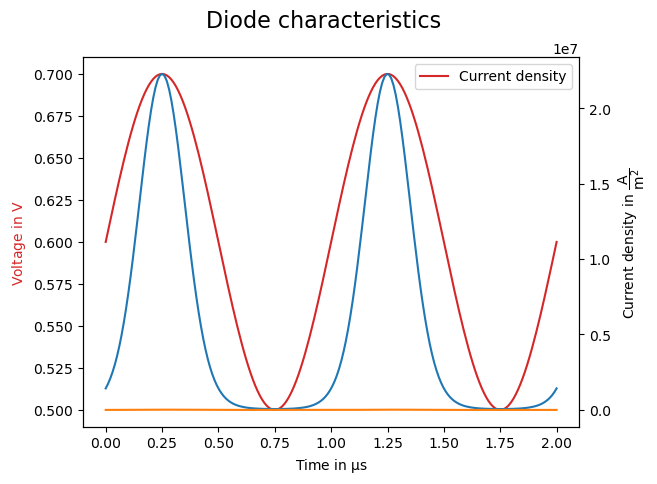

In [16]:
#
# Transistor
#
fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Diode characteristics", fontsize=16)

axis.plot(time * 1E6, base_voltage, label='Current density', color='tab:red')

axis.set_xlabel(r"Time in $\mathrm{\mu s}$")
axis.set_ylabel(r"Voltage in $\mathrm{V}$", color='tab:red')

axis.legend()
#plt.ylim(-1E-6,1E-6)
#plt.show()


axis2 = axis.twinx()

axis2.plot(time * 1E6, collector_current_000, label='Current density')
axis2.plot(time * 1E6, base_current_000, label='Current density')

axis2.set_ylabel(r"Current density in $\mathrm{\dfrac{A}{m^2}}$")
#plt.ylim(-1E-6,1E-6)
plt.show()

In [17]:


d_t = 0.0001E-6



In [19]:
parameters.u = sicher.copy()
#
# Simulation at f=100MHz
#
u_dc_collector = 2.0
u_dc_base = 0.6
u_ac_base = 0.1
d_t = 0.0001E-6
t_steps = 200 #200 
f = 100E6

base_current_100MHz_000 = []
base_current_100MHz_599 = []

collector_current_100MHz_000 = []
collector_current_100MHz_599 = []

base_voltage_100MHz = []

time = np.linspace(0, d_t * t_steps, t_steps)
for t in time:
    
    volt_base = u_dc_base + u_ac_base*np.sin(2*np.pi*f*t)
    
    print("### Voltage:", volt_base)
    print("### Steps:", t)
    
    solver.time_step()
    solver.solve_bias_center_boundary_transient(.0 , u_dc_collector, volt_base, 650E-9, "p", d_t)
    
    j_p = hole_current_density()
    j_n = electron_current_density()
    
    base_current_100MHz_000.append(-j_p[000])
    base_current_100MHz_599.append(-j_p[parameters.n-1])
    
    collector_current_100MHz_000.append(-j_n[000])
    collector_current_100MHz_599.append(-j_n[parameters.n-1])
    
    base_voltage_100MHz.append(volt_base)

### Voltage: 0.6
### Steps: 0.0
### Voltage: 0.6063105631312673
### Steps: 1.0050251256281407e-10
### Voltage: 0.6125959705067717
### Steps: 2.0100502512562814e-10
### Voltage: 0.6188311666489718
### Steps: 3.015075376884422e-10
### Voltage: 0.6249912962370308
### Steps: 4.0201005025125627e-10
### Voltage: 0.6310518031874168
### Steps: 5.025125628140703e-10
### Voltage: 0.6369885285416547
### Steps: 6.030150753768844e-10
### Voltage: 0.6427778067710209
### Steps: 7.035175879396985e-10
### Voltage: 0.6483965601142838
### Steps: 8.040201005025125e-10
### Voltage: 0.6538223905724289
### Steps: 9.045226130653266e-10
### Voltage: 0.6590336691936528
### Steps: 1.0050251256281406e-09
### Voltage: 0.6640096222927107
### Steps: 1.1055276381909548e-09
### Voltage: 0.6687304142609184
### Steps: 1.2060301507537688e-09
### Voltage: 0.6731772266367076
### Steps: 1.3065326633165828e-09
### Voltage: 0.6773323331215338
### Steps: 1.407035175879397e-09
### Voltage: 0.6811791702421021
### Steps: 1.507537

### Voltage: 0.6986292838338003
### Steps: 1.2763819095477386e-08
### Voltage: 0.6973914308085538
### Steps: 1.28643216080402e-08
### Voltage: 0.695765346971593
### Steps: 1.2964824120603015e-08
### Voltage: 0.6937575143700825
### Steps: 1.306532663316583e-08
### Voltage: 0.6913759368137438
### Steps: 1.3165829145728642e-08
### Voltage: 0.6886301079693209
### Steps: 1.3266331658291457e-08
### Voltage: 0.6855309735160413
### Steps: 1.3366834170854271e-08
### Voltage: 0.6820908875129263
### Steps: 1.3467336683417086e-08
### Voltage: 0.6783235631518891
### Steps: 1.3567839195979898e-08
### Voltage: 0.6742440180929283
### Steps: 1.3668341708542713e-08
### Voltage: 0.6698685145993307
### Steps: 1.3768844221105527e-08
### Voltage: 0.6652144947115188
### Steps: 1.3869346733668342e-08
### Voltage: 0.6603005107179615
### Steps: 1.3969849246231156e-08
### Voltage: 0.6551461512003109
### Steps: 1.4070351758793969e-08
### Voltage: 0.6497719629475684
### Steps: 1.4170854271356783e-08
### Voltage: 0

In [ ]:
#
# Transistor
#
fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Diode characteristics", fontsize=16)

axis.plot(time * 1E6, base_voltage, label='Current density', color='tab:red')

axis.set_xlabel(r"Time in $\mathrm{\mu s}$")
axis.set_ylabel(r"Voltage in $\mathrm{V}$", color='tab:red')

axis.legend()
#plt.ylim(-1E-6,1E-6)
#plt.show()



axis2 = axis.twinx()

axis2.plot(time * 1E6, collector_current_000, label='Current density')
axis2.plot(time * 1E6, base_current_000, label='Current density')

axis2.set_ylabel(r"Current density in $\mathrm{\dfrac{A}{m^2}}$")

#plt.ylim(-1E-6,1E-6)
plt.show()

In [ ]:



d_t = 0.01E-9





In [ ]:
parameters.u = sicher.copy()

#
# Simulation at f=500MHz
#


u_dc_collector = 2.0
u_dc_base = 0.6
u_ac_base = 0.1
d_t = 0.01E-9
t_steps = 100 #200 
f = 0.5E9

base_current_500MHz_000 = []
base_current_500MHz_599 = []

collector_current_500MHz_000 = []
collector_current_500MHz_599 = []

base_voltage_500MHz = []

time_500MHz = np.linspace(0, d_t * t_steps, t_steps)


for t in time_500MHz:
    
    volt_base = u_dc_base + u_ac_base*np.sin(2*np.pi*f*t)
    
    print("### Voltage:", volt_base)
    print("### Steps:", t)
    solver.time_step()
    solver.solve_bias_center_boundary_transient(.0 , u_dc_collector, volt_base, 650E-9, "p", d_t)
    
    j_p = hole_current_density()
    j_n = electron_current_density()
    
    
    base_current_500MHz_000.append(-j_p[000])
    base_current_500MHz_599.append(-j_p[parameters.n-1])
    
    
    collector_current_500MHz_000.append(-j_n[000])
    collector_current_500MHz_599.append(-j_n[parameters.n-1])
    
    
    base_voltage_500MHz.append(volt_base)

In [ ]:
#
# Transistor
#
fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Diode characteristics", fontsize=16)

axis.plot(time_500MHz * 1E9, base_voltage_500MHz, label='Base voltage', color='tab:red')


axis.set_xlabel(r"Time in $\mathrm{ns}$")
axis.set_ylabel(r"Voltage in $\mathrm{V}$", color='tab:red')
axis.legend()

#plt.ylim(-1E-6,1E-6)
#plt.show()

axis2 = axis.twinx()

axis2.plot(time_500MHz * 1E9, collector_current_500MHz_000, label='Collector current density')
axis2.plot(time_500MHz * 1E9, base_current_500MHz_000, label='Base current density')


axis2.set_ylabel(r"Current density in $\mathrm{\dfrac{A}{m^2}}$")

axis2.legend()

#plt.xlim(0,10)
#plt.ylim(-1E-6,1E-6)
plt.show()#parameters

In [ ]:

parameters.u = sicher.copy()
#
# Simulation at f=1GHz
#
u_dc_collector = 2.0
u_dc_base = 0.6
u_ac_base = 0.1
d_t = 0.01E-9
t_steps = 200 #200 
f = 1.0E9
base_current_1GHz_000 = []
base_current_1GHz_599 = []
collector_current_1GHz_000 = []
collector_current_1GHz_599 = []
base_voltage_1GHz = []
time_1GHz = np.linspace(0, d_t * t_steps, t_steps)
for t in time_1GHz:
    volt_base = u_dc_base + u_ac_base*np.sin(2*np.pi*f*t)
    
    print("### Voltage:", volt_base)
    print("### Steps:", t)
    
    solver.time_step()
    solver.solve_bias_center_boundary_transient(.0 , u_dc_collector, volt_base, 650E-9, "p", d_t)
    
    j_p = hole_current_density()
    j_n = electron_current_density()
    
    base_current_1GHz_000.append(-j_p[000])
    base_current_1GHz_599.append(-j_p[599])
    
    collector_current_1GHz_000.append(-j_n[000])
    collector_current_1GHz_599.append(-j_n[599])
    
    base_voltage_1GHz.append(volt_base)

In [ ]:
#
# Transistor
#
fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Diode characteristics", fontsize=16)

axis.plot(time_1GHz * 1E9, base_voltage_1GHz, label='Base voltage', color='tab:red')

axis.set_xlabel(r"Time in $\mathrm{ns}$")
axis.set_ylabel(r"Voltage in $\mathrm{V}$", color='tab:red')

axis.legend()

#plt.ylim(-1E-6,1E-6)
#plt.show()

axis2 = axis.twinx()

axis2.plot(time_1GHz * 1E9, collector_current_1GHz_000, label='Current density')
axis2.plot(time_1GHz * 1E9, base_current_1GHz_000, label='Current density')

axis2.set_ylabel(r"Current density in $\mathrm{\dfrac{A}{m^2}}$")

#plt.ylim(-1E-6,1E-6)
plt.show()

In [ ]:


f = 1E9




In [ ]:

parameters.u = sicher.copy()
#
# Simulation at f=1GHz
#

u_dc_collector = 2.0
u_dc_base = 0.6
u_ac_base = 0.1
d_t = 0.01E-9
t_steps = 200 #200 
f = 1E9

base_current_000 = []
base_current_599 = []
collector_current_000 = []
collector_current_599 = []
base_voltage = []
time = np.linspace(0, d_t * t_steps, t_steps)



for t in time:
    volt_base = u_dc_base + u_ac_base*np.sin(2*np.pi*f*t)
    
    print("### Voltage:", volt_base)
    print("### Steps:", t)
    
    solver.time_step()
    solver.solve_bias_center_boundary_transient(.0 , u_dc_collector, volt_base, 650E-9, "p", d_t)
    
    j_p = hole_current_density()
    j_n = electron_current_density()
    
    base_current_000.append(-j_p[000])
    base_current_599.append(-j_p[599])
    
    collector_current_000.append(-j_n[000])
    collector_current_599.append(-j_n[599])
    
    base_voltage_1GHz.append(volt_base)

In [ ]:
#
# Transistor
#
fig, axis = plt.subplots(1,1, sharey=True)
fig.suptitle("Diode characteristics", fontsize=16)

axis.plot(time * 1E9, base_voltage, label='Current density', color='tab:red')

axis.set_xlabel(r"Time in $\mathrm{\mu s}$")
axis.set_ylabel(r"Voltage in $\mathrm{V}$", color='tab:red')
axis.legend()

#plt.ylim(-1E-6,1E-6)
#plt.show()

axis2 = axis.twinx()
axis2.plot(time * 1E9, collector_current_000, label='Current density')
axis2.plot(time * 1E9, base_current_000, label='Current density')


print(collector_current_000)
print(base_current_000)
axis2.set_ylabel(r"Current density in $\mathrm{\dfrac{A}{m^2}}$")
#plt.ylim(-1E-6,1E-6)
plt.show()